# Clustering with K-Means (Final)

In order to identify areas of focus, we will do clustering to determine the various clusters. Our focus is to identify most efficient route for patrolling, therefore, narrowing it down to area based since police department patrol routes would be within their area of jurisdiction. 

## Loading the libraries

In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import HeatMap, MarkerCluster, AntPath
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, label

In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

## Load data

In [3]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
df = utils.feature_engineering(df)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 22:24:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
print(df.columns)

['Date Rptd', 'Date OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'LAT', 'LON', 'Occ DateTime', 'hour', 'time_slot', 'Year OCC', 'Month OCC', 'Day OCC', 'age_group', 'Category']


Keeping only the AREA, LAT, LON for clustering purpose, since these are the information for routing. 

In [20]:
columns_to_drop = ['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'Year OCC', 'Month OCC', "Occ DateTime", 'Day OCC', 'Category', 'hour', "age_group", 'time_slot']
df_clean = utils.drop_columns(df, columns_to_drop)

In [21]:
df_pd = df_clean.toPandas()
df_pd.head()

,AREA,Vict Age,LAT,LON
0,1,47,34.0444,-118.2628
1,3,19,34.0210,-118.3002
2,9,19,34.1576,-118.4387
3,6,28,34.0944,-118.3277
4,18,41,33.9467,-118.2463


In [22]:
# save the data for easy retrieval
df_pd.to_pickle("clusters/data_for_clusterings.pkl")

We will focus from the highest crime rate to the lowest crime rate area.

In [23]:
crime_rate_by_area = df_pd[["AREA"]].groupby("AREA").size().sort_values(ascending=False)
sorted_area = crime_rate_by_area.index.to_list()
print(sorted_area)

[1, 3, 12, 14, 6, 18, 15, 20, 7, 21, 13, 9, 8, 2, 10, 19, 11, 17, 5, 16, 4]


## Elbow Method for determine the number of clusters

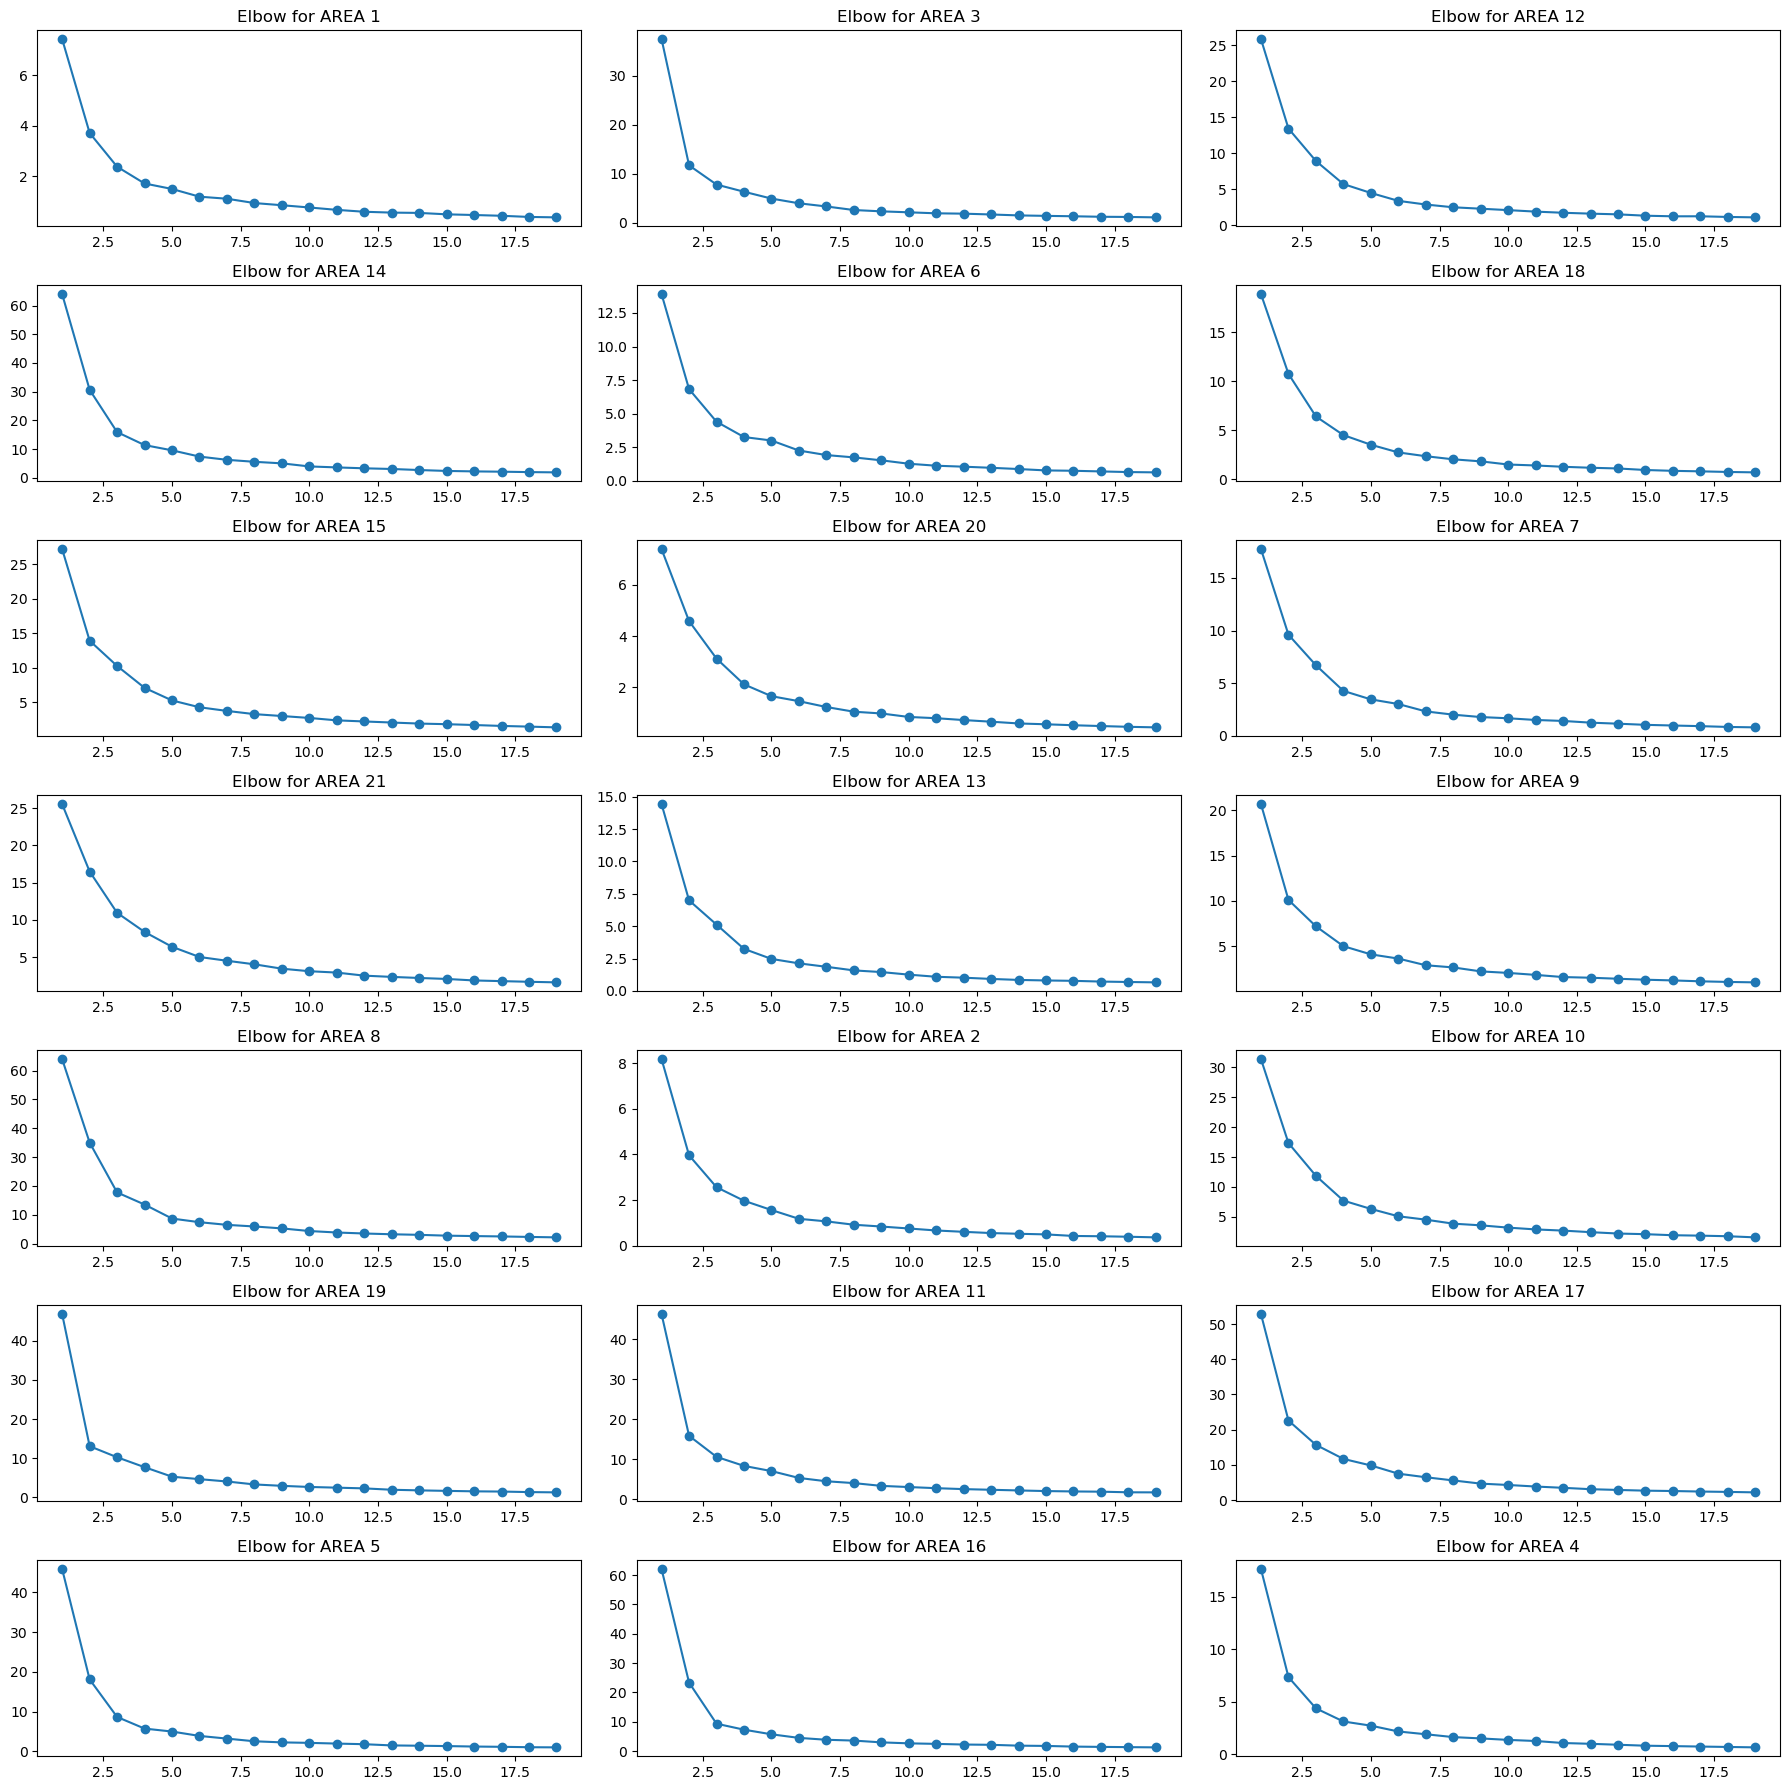

In [10]:
fig, axes = plt.subplots(7, 3, figsize=(18, 18))  # 2 rows, 1 column

for i, ax in enumerate(axes.flat):
    wcss = []  # List to store WCSS for each k
    df_spatial = df_pd[df_pd["AREA"]==sorted_area[i]]
    df_spatial = df_spatial[["AREA", "LAT", "LON"]]
    # Loop through a range of k values
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_spatial)  # Fit K-means
        wcss.append(kmeans.inertia_)  # Append WCSS (inertia) for this k
        
    ax.plot(range(1, 20), wcss, marker='o')
    ax.set_title(f"Elbow for AREA {sorted_area[i]}")
    
    
plt.tight_layout()
plt.show()

## Clustering with K-Means for Area 1 (Central)

Using k=10 for generalization across the areas.

In [24]:
data = pd.read_pickle("clusters/data_for_clusterings.pkl")

In [25]:
df_area_1 = data[data["AREA"]==1]
df_clusters = df_area_1[["LAT", "LON"]]
n_clusters = 10
kmeans_central = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_central.fit(df_clusters)
df_area_1["cluster"] = kmeans_central.labels_
df_area_1.head()

/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_56058/3488554445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_1["cluster"] = kmeans_central.labels_


,AREA,Vict Age,LAT,LON,cluster
0,1,47,34.0444,-118.2628,9
5,1,25,34.0415,-118.2620,9
50,1,22,34.0466,-118.2590,3
101,1,59,34.0570,-118.2508,4
117,1,36,34.0438,-118.2547,3


Plot the clusters result.

In [14]:
m = folium.Map(location=[df_area_1['LAT'].mean(), df_area_1['LON'].mean()], zoom_start=15)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue', 'cadetblue', 'darkpurple']
# Add points to the map
count = 0
for i, row in df_area_1.iterrows():
    count+=1
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=8,
        color=colors[int(row['cluster'])],
        fill=True,
        fill_color=colors[int(row['cluster'])],
        fill_opacity=0.6,
        popup=f"Cluster: {int(row['cluster'])}"
    ).add_to(m)
print(count)

m.save('clusters/central_10_kmeans_age.html')

50751


Determining density points.

/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_56058/925417783.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


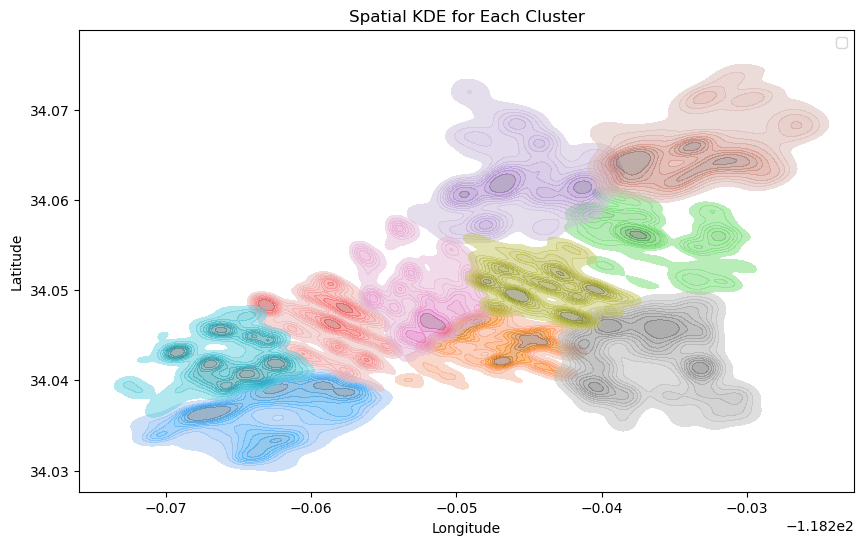

In [16]:
# Plot KDE for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(df_area_1["cluster"]):
    if cluster_id == -1:
        continue  # Skip noise points

    cluster_data = df_area_1[df_area_1["cluster"] == cluster_id]
    sns.kdeplot(x=cluster_data["LON"], y=cluster_data["LAT"], 
                fill=True, label=f"Cluster {cluster_id}", alpha=0.5)

    
plt.title("Spatial KDE for Each Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

Find the highest density points in each of the clusters.

In [27]:
densest_points = {}
for cluster_id in np.unique(df_area_1["cluster"]):
    if cluster_id == -1:
        continue  # Skip noise points

    cluster_data = df_area_1[df_area_1["cluster"] == cluster_id]
    
    # Apply KDE on cluster
    kde = gaussian_kde(cluster_data[['LAT', 'LON']].T)
    
    # Define grid for KDE evaluation
    lat_min, lat_max = cluster_data['LAT'].min() - 0.01, cluster_data['LAT'].max() + 0.01
    lon_min, lon_max = cluster_data['LON'].min() - 0.01, cluster_data['LON'].max() + 0.01
    lat_grid, lon_grid = np.mgrid[lat_min:lat_max:100j, lon_min:lon_max:100j]
    positions = np.vstack([lat_grid.ravel(), lon_grid.ravel()])
    density = kde(positions).reshape(lat_grid.shape)
    
    max_density_index = np.unravel_index(np.argmax(density), density.shape)
    max_density_coords = lat_grid[max_density_index], lon_grid[max_density_index]
    densest_points[cluster_id] = max_density_coords
    # densest_points.append(max_density_coords)
    

In [28]:
print(densest_points)

{0: (34.036454545454546, -118.26722727272727), 1: (34.04208787878788, -118.2468686868687), 2: (34.05622727272727, -118.2376), 3: (34.048360606060605, -118.26308181818182), 4: (34.06184747474747, -118.2468090909091), 5: (34.06428181818182, -118.23791818181817), 6: (34.046469696969694, -118.25197272727273), 7: (34.045980808080806, -118.23947171717171), 8: (34.04959090909091, -118.24594848484848), 9: (34.04322222222222, -118.2692888888889)}


In [26]:
df_area_1.to_pickle("clusters/area1_clusters_age.pkl")